In [86]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [87]:
data = pd.read_csv('Turbine_Data_project.csv')
data.head()

,Unnamed: 0,WindSpeed,WindDirection,Power
0,0,0.0,0.0,0.0
1,1,0.0,0.0,0.0
2,2,0.0,0.0,0.0
3,3,0.0,0.0,0.0
4,4,0.0,0.0,0.0


In [88]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,WindSpeed,WindDirection,Power
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [89]:
x = tf.cast(data.drop(['Power'], axis=1), tf.float32)
y = tf.cast(data['Power'], tf.float32)

def normalize(x):
    return (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x))

x = normalize(x)
# y = normalize(y)

In [90]:
def train_test_split(x, y, train_size=0.8):
    train_size = int(train_size * len(x))
    x_train, x_valid = x[:train_size], x[train_size:]
    y_train, y_valid = y[:train_size], y[train_size:]
    return x_train, x_valid, y_train, y_valid

x_train, x_test, y_train, y_test = train_test_split(x, y) # 80% train, 20% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9) # from train, 90% train, 10% validation

# checking the shapes
print(x_train.shape, x_val.shape, x_test.shape) # x_train[:,0] : wind speed, x_train[:,1] :  wind direction
print(y_train.shape, y_val.shape, y_test.shape) # y_train : power

(85121, 2) (9458, 2) (23645, 2)
(85121,) (9458,) (23645,)


In [95]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(2,), kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

model = create_model()
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 64)                192       
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [92]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
model.evaluate(x_test, y_test)

Epoch 1/10
   1/2661 [..............................] - ETA: 29:33 - loss: 0.5100 - mse: 0.5100

2022-11-21 14:50:52.966206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0217

2022-11-21 14:51:24.139068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2661/2661 [==============================] - 33s 12ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 2/10
2661/2661 [==============================] - 32s 12ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/10
2661/2661 [==============================] - 23s 9ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/10
2661/2661 [==============================] - 23s 9ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/10
2661/2661 [==============================] - 23s 9ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/10
2661/2661 [==============================] - 23s 9ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/10
2661/2661 [==============================] - 22s 8ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/10
2661/2661 [==============================] - 23s 9ms/

[0.002335387747734785, 0.002335387747734785]

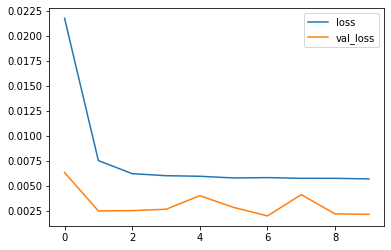

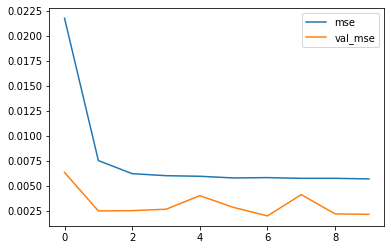

In [94]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.legend()
plt.show()